In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df1 = pd.read_csv('flights.csv', low_memory=False)

In [34]:
df2 = pd.read_csv('airports.csv', low_memory=False)
df3 = pd.read_csv('airlines.csv', low_memory=False)

In [35]:
df1_mask = df1[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)
df1 = df1.loc[~df1_mask]
df1['DATE'] = pd.to_datetime(df1[['YEAR', 'MONTH', 'DAY']])
df1 = df1.drop(columns=['YEAR', 'MONTH', 'DAY'])
cols = list(df1.columns)
cols[-1:] + cols[:-1]
df1 = df1[cols[-1:] + cols[:-1]]
#рассматриваем только те рейсы, у которых время задержки вылета положительно(иначе это не задержка),
#а также рейсы не частных авиакомпаний и не из частных аэропортов

df = df1[df1['DEPARTURE_DELAY'] >= 0]
df = df[df['ORIGIN_AIRPORT'].str.match(r'^[A-Za-z]', na=False)]
df = df[(df['TAIL_NUMBER'].str.match(r'^[A-Za-z]', na=False))]
#df2 = df2[~df2['IATA_CODE'].str.match(r'^\d+$', na=False)]


1. Посмотрим, как распределено среднее время задержки по месяцам

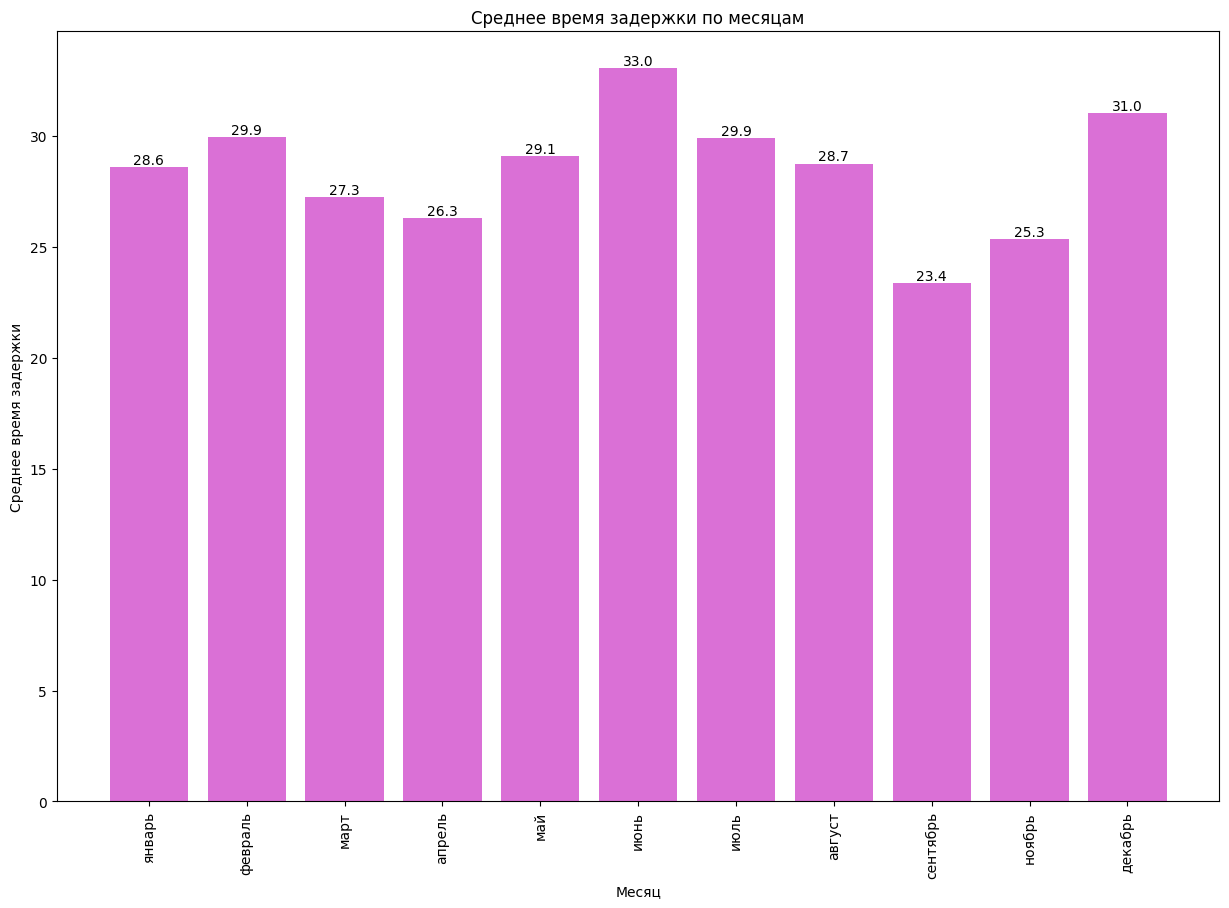

In [36]:
df['MONTH'] = df['DATE'].dt.month
flightcount_df = df.groupby('MONTH')['DEPARTURE_DELAY'].mean().reset_index(name='FLIGHT_COUNT')
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
flightcount_df['MONTH'] = flightcount_df['MONTH'].map(lambda x: months[x-1])
plt.figure(figsize = (15, 10))
bars = plt.bar(flightcount_df['MONTH'], flightcount_df['FLIGHT_COUNT'], color = 'orchid')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=10)
plt.xlabel('Месяц')
plt.ylabel('Среднее время задержки')
plt.title('Среднее время задержки по месяцам')
plt.xticks(rotation = 90)

plt.show()



Видим, что наибольшее среднее время задержки в феврале, июне и декабре. Это может быть связано с увеличением нагрузки на аэропорты в эти месяцы в связи с началом сезона отпусков и плохими погодными условиями в зимние месяцы.

2. Далее проверим, как обстоят дела со средним временем задержки по дням недели

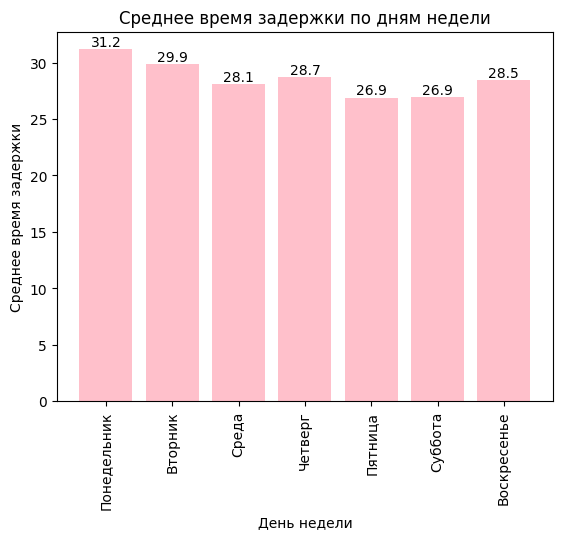

In [37]:
meandelay_df = df.groupby("DAY_OF_WEEK")["DEPARTURE_DELAY"].mean().reset_index(name = 'MEAN_DELAY')
days_of_week = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
meandelay_df['DAY_OF_WEEK'] = meandelay_df['DAY_OF_WEEK'].map(lambda x: days_of_week[x-1])
bars = plt.bar(meandelay_df['DAY_OF_WEEK'], meandelay_df['MEAN_DELAY'], color = 'pink')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=10)
plt.xlabel('День недели')
plt.ylabel('Среднее время задержки')
plt.title('Среднее время задержки по дням недели')
plt.xticks(rotation = 90)

plt.show()

Видим, что наибольшее время задержки в начале рабочей недели. Это может быть связано с началом рабочей недели, из-за чего повышается нагрузка на аэропорты.

3. Далее рассмотрим, как распределено среднее время задержки в течение дня

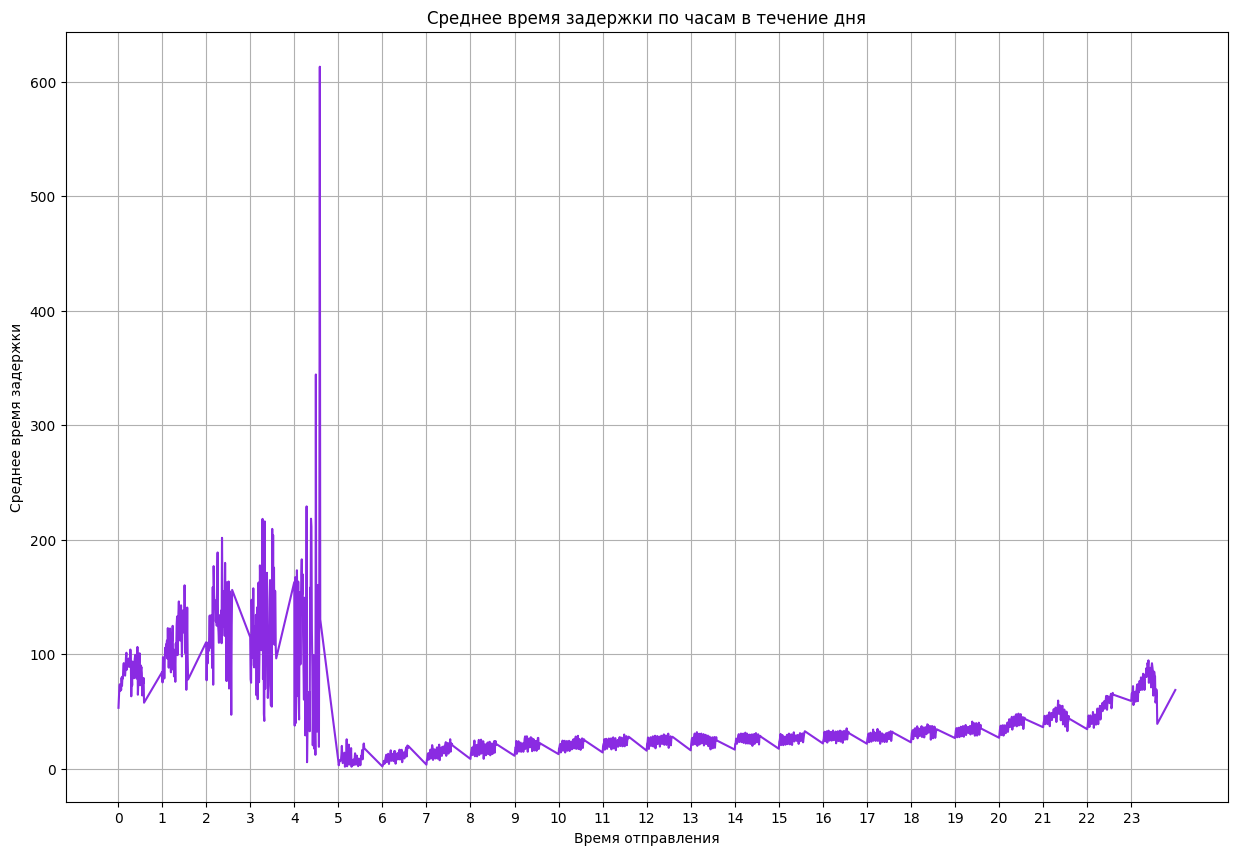

In [38]:

delaytime_df = df.groupby(['DEPARTURE_TIME'])['DEPARTURE_DELAY'].mean().reset_index(name = 'DELAY_COUNT')
plt.figure(figsize=(15, 10))
plt.plot(delaytime_df['DEPARTURE_TIME']/100, delaytime_df['DELAY_COUNT'], color = 'blueviolet')
plt.grid()
plt.xlabel('Время отправления')
plt.ylabel('Среднее время задержки')
plt.title('Среднее время задержки по часам в течение дня')
plt.xticks(ticks=range(0, 24), labels=[str(i) for i in range(24)])

plt.show()

Наиболее длительные задержки приходятся на ночные часы, а днем среднее время задержки существенно меньше. Это может быть связано с ухудшением видимости ночью или с недостатком рабочего персонала в ночную смену.

4. Далее рассмотрим, как зависят количество задержек и среднее время задержки вылета от авиакомпании

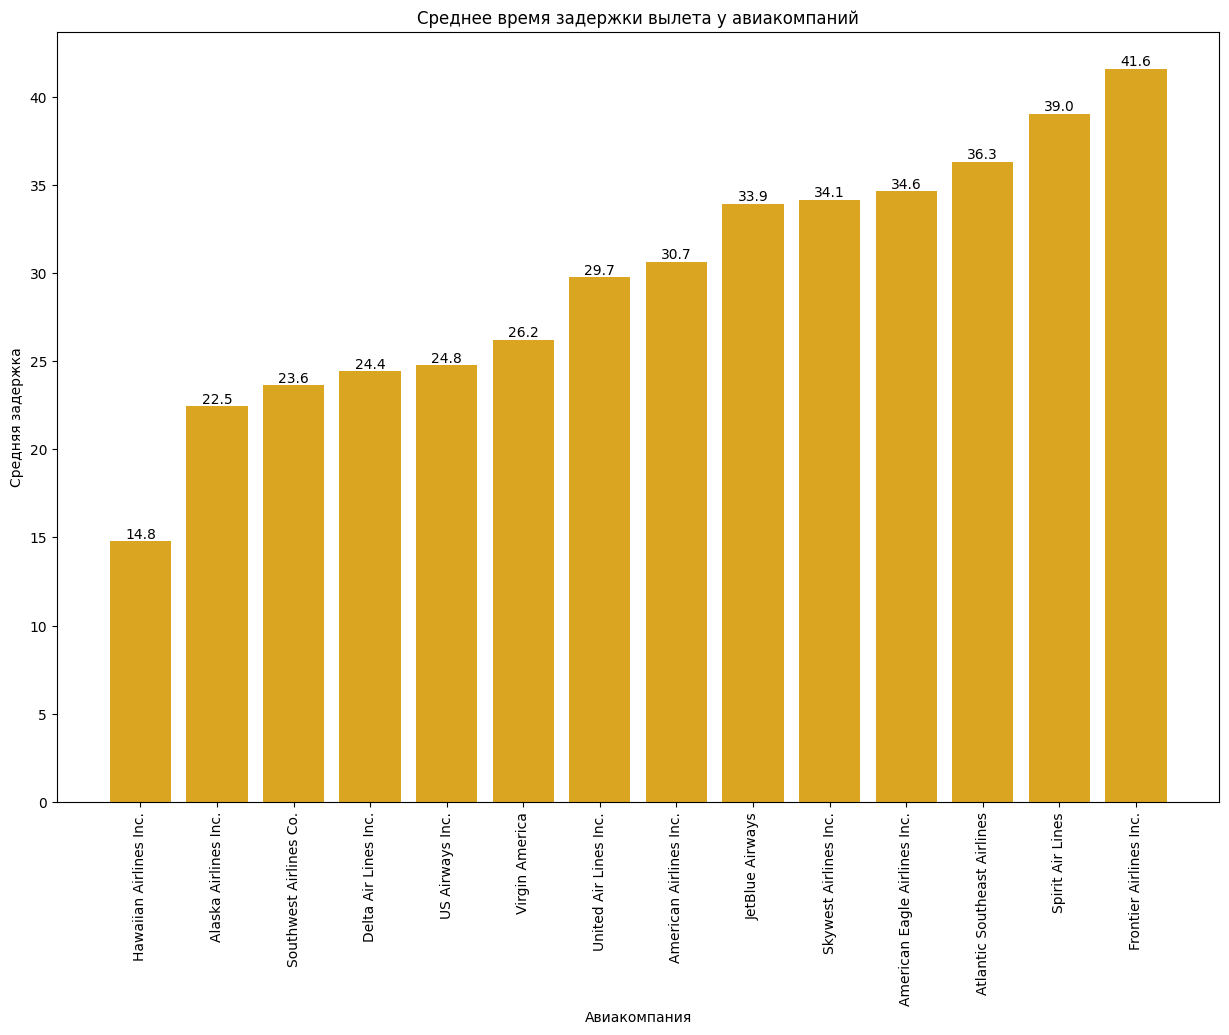

In [39]:

flights_with_airlines = pd.merge(df, df3, left_on='AIRLINE', right_on='IATA_CODE', how='left')
airlineavgdelay = flights_with_airlines.groupby('AIRLINE_y')['DEPARTURE_DELAY'].mean().sort_values().reset_index(name = 'DELAY_AVG')
plt.figure(figsize=(15, 10))
bars = plt.bar(airlineavgdelay['AIRLINE_y'], airlineavgdelay['DELAY_AVG'], color = 'goldenrod')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=10)
plt.title('Среднее время задержки вылета у авиакомпаний')
plt.xlabel('Авиакомпания')
plt.ylabel('Средняя задержка')
plt.xticks(rotation=90)
plt.show()

Выявили компанию с наибольшим средним временем задержки. Это компания Frontier Airlines. Это может говорить о недостатке работников в этой авиакомпании, проблемах с техническим обслуживанием или о том, что она чаще всего обслуживает отдаленные, плохо развитые аэропорты

5. Проанализируем, как зависит среднее время задержки от аэропорта вылета

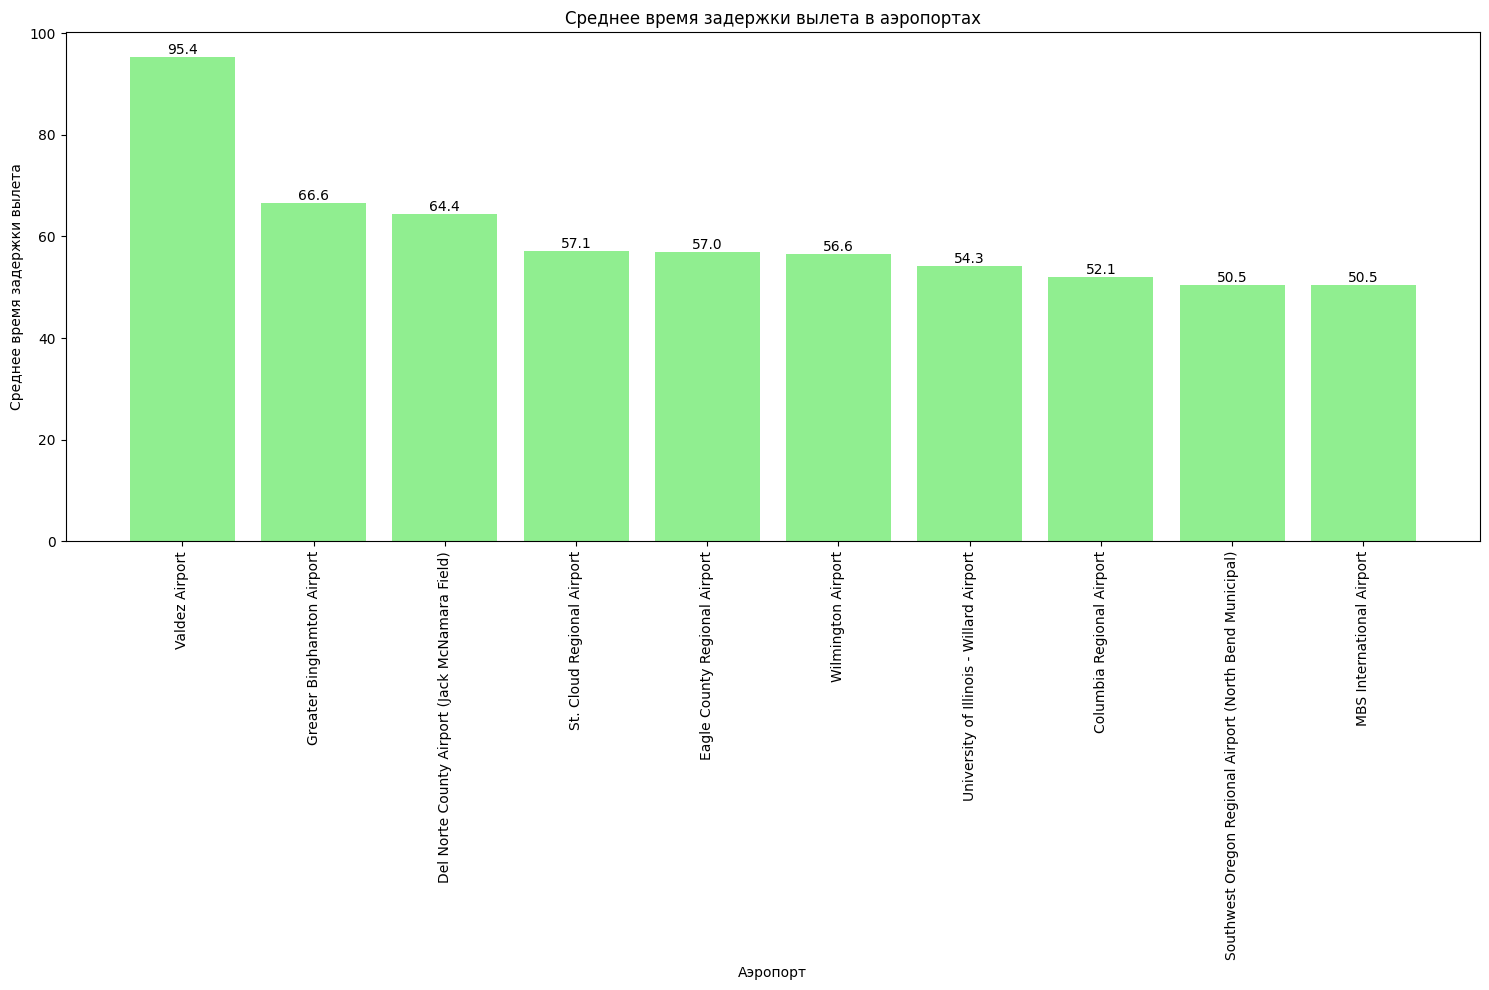

In [40]:

avg_delay_by_airport = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().reset_index()
avg_delay_by_airport.rename(columns={'ORIGIN_AIRPORT': 'IATA_CODE', 'DEPARTURE_DELAY': 'AVG_DEPARTURE_DELAY'}, inplace=True)
airports_with_delay = pd.merge(df2, avg_delay_by_airport, on='IATA_CODE', how='left')
top_airports_delay = airports_with_delay.nlargest(10, 'AVG_DEPARTURE_DELAY')
plt.figure(figsize=(15, 10))
bars = plt.bar(top_airports_delay['AIRPORT'], top_airports_delay['AVG_DEPARTURE_DELAY'], color='lightgreen')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=10)
plt.title('Среднее время задержки вылета в аэропортах')
plt.xlabel('Аэропорт')
plt.ylabel('Среднее время задержки вылета')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Лидер по времени задержки - аэропорт Valdez. В среднем задержка составляет около 1.5 часов. Министерству транспорта стоит проверить его. Возможно, там есть проблемы с персоналом, техникой, финансированием.

6. Далее проверим, какие причины чаще всего приводят к задержкам вылетов

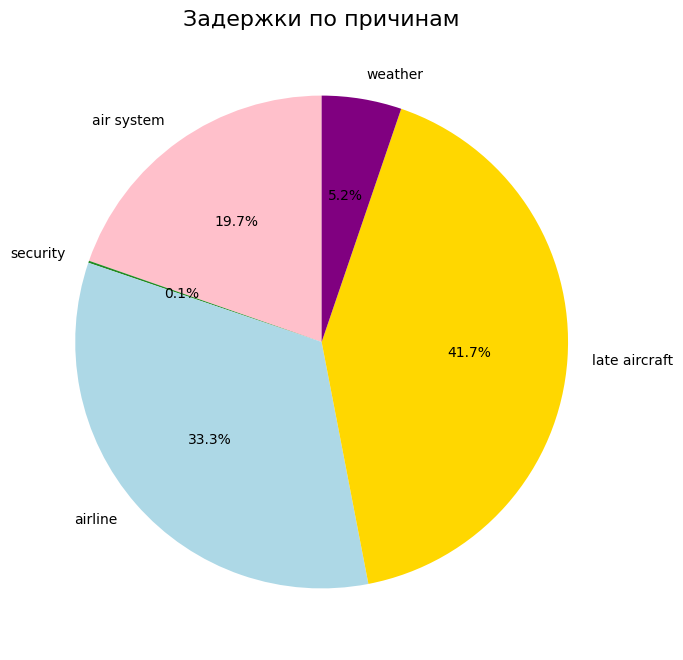

In [41]:

delay_causes = df[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].sum()
labels = ['air system', 'security', 'airline', 'late aircraft', 'weather']
plt.figure(figsize=(8, 8))
plt.pie(delay_causes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['pink', 'forestgreen', 'lightblue', 'gold', 'purple'])
plt.title('Задержки по причинам', fontsize=16)
plt.show()

Самые частые причины задержек - позднее прибытие самолета и проблемы внутри авиакомпании. Причина позднего прибытия самолета обьясняется тем, что опоздавший самолет в свой предыдущий полет уже вылетел с задержкой. То есть получается замкнутый круг: причиной задержки является предыдущая задержка.
Вторая по распространенности причина заключается в проблемах на стороне авиакомпании. Это могут быть финансовые проблемы (условно авиакомпания не рассчитала затраты на топливо и самолет задерживается в ожидании заправки или у компании нет денег на качественное техобслуживание самолетов), или ошибки авиакомпании в планировании полетов, или компания из-за забастовки работников задерживает рейс